In [1]:
# remove this
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

#sys.path.append("/Users/harrison37/Work/alpine/ascent/install-debug/python-modules/")
sys.path.append("/Users/larsen30/research/test_builds/release/ascent/install/python-modules")

# Ascent imports
import conduit
import conduit.blueprint
import ascent

In [2]:
# cleanup any old results
!./cleanup.sh

In [3]:
def create_mesh(time):

    mesh1 = conduit.Node()
    dims = 20
    conduit.blueprint.mesh.examples.braid("hexs",
                                          dims,
                                          dims,
                                          dims,
                                          mesh1)

    field = mesh1["fields/gyre"]
    field["association"] = "vertex"
    field["topology"] = "mesh"
    # https://shaddenlab.berkeley.edu/uploads/LCS-tutorial/examples.html
    values = np.zeros(dims*dims*dims)


    e = 0.25
    A = 0.1
    w = (2.0 * math.pi) / 10.0
    a_t = e * math.sin(w * time)
    b_t = 1.0 - 2 * e * math.sin(w * time)
    #print("e: " + str(e) + " A " + str(A) + " w " + str(w) + " a_t " + str(a_t) + " b_t " + str(b_t))
    #print(b_t)
    #print(w)
    idx = 0
    for z in range(dims):
        for y in range(dims):
            # scale y to 0-1
            y_n = float(y)/float(dims)
            y_t = math.sin(math.pi * y_n)
            for x in range(dims):
                # scale x to 0-1
                x_f = float(x)/ (float(dims) * .5)
                f_t = a_t * x_f * x_f + b_t * x_f
                #print(f_t)
                value = A * math.sin(math.pi * f_t) * y_t
                u = -math.pi * A * math.sin(math.pi * f_t) * math.cos(math.pi * y_n)
                df_dx = 2.0 * a_t + b_t
                #print("df_dx " + str(df_dx))
                v = math.pi * A * math.cos(math.pi * f_t) * math.sin(math.pi * y_n) * df_dx
                values[idx] = math.sqrt(u * u + v * v)
                #values[idx] = u * u + v * v
                #values[idx] = value
                #print("u " + str(u) + " v " + str(v) + " mag " + str(math.sqrt(u * u + v * v)))
                idx = idx + 1

    #print(values)
    field["values"] = values

    verify_info = conduit.Node()
    if not conduit.blueprint.mesh.verify(mesh1,verify_info):
        print("Mesh Verify failed!")
        print(verify_info)
    else:
        print("Mesh verify success!")        
    
    return mesh1


In [4]:

# Jupyter imports
from IPython.display import Image
# helper we use when displaying results in the notebook
img_display_width = 500



# open ascent
a = ascent.Ascent()
a.open()



# Setup actions to tell Ascent what to do
# add our expressions definiton to the actions 
actions = conduit.Node()
add_act = actions.append()
add_act["action"] = "add_queries"

# declare a scene to render the dataset
queiries = add_act["queries"] 
queiries["q1/params/expression"] = "cycle()"
queiries["q1/params/name"] = "my_cycle"

queiries["q2/params/expression"] = "entropy(histogram(field(\"gyre\"), num_bins=128))"
queiries["q2/params/name"] = "entropy_of_gyre"

# declare a scene to render the dataset
add_scenes = actions.append()
add_scenes["action"] = "add_scenes"
scenes = add_scenes["scenes"] 
scenes["s1/plots/p1/type"] = "pseudocolor"
scenes["s1/plots/p1/field"] = "gyre"
# Set the output file name (ascent will add ".png")
scenes["s1/image_name"] = "out_gyre"

# view our full actions tree
print(actions.to_yaml())

nsteps = 3
time = 0.0
delta_time = 0.5

info = conduit.Node()
for step in range(nsteps):
    # create example mesh using conduit blueprint
    mesh = create_mesh(time)
    # update the examples default cycle
    mesh["state/cycle"] = 100 + step * 100
    time = time + delta_time
    # publish mesh to ascent
    a.publish(mesh)
    
    # update image name
    scenes["s1/image_name"] = "out_gyre_%04d" % step;
    # execute
    a.execute(actions)
    # get the results of the query
    
    #print(info["expressions"].to_yaml())

# close ascent

a.info(info)
print(info.to_yaml())
#print("Created {}".format(info["images"][0]["image_name"]))
print(info["expressions"].to_yaml())
a.close()


- 
  action: "add_queries"
  queries: 
    q1: 
      params: 
        expression: "cycle()"
        name: "my_cycle"
    q2: 
      params: 
        expression: "entropy(histogram(field(\"gyre\"), num_bins=128))"
        name: "entropy_of_gyre"
- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "gyre"
      image_name: "out_gyre"

Mesh verify success!
Mesh verify success!
Mesh verify success!

runtime: 
  type: "ascent"
registered_filter_types: 
  filters: 
    blueprint_verify: "blueprint_verify"
    ensure_low_order: "ensure_low_order"
    ensure_blueprint: "ensure_blueprint"
    relay_io_load: "relay_io_load"
    basic_trigger: "basic_trigger"
    basic_query: "basic_query"
    default_render: "default_render"
    ensure_vtkh: "ensure_vtkh"
    ensure_vtkm: "ensure_vtkm"
    vtkh_bounds: "vtkh_bounds"
    vtkh_union_bounds: "vtkh_union_bounds"
    vtkh_domain_ids: "vtkh_domain_ids"
    vtkh_union_domain_ids: "vtk

In [5]:
pattern = "out_gyre_%04d.png"
data = []
for i in range(nsteps):
    with open(pattern % i, "rb") as f:
        data.append(f.read())

In [6]:
import ipywidgets as widgets
 
image = widgets.Image(value=data[0],
    width=500,
    height=500,
    format="jpg")
 
play = widgets.Play(value=0,
    min=0,
    max=len(data)-1,
    step=1,
    interval=500)
 
def update(change):
    index = change.owner.value
    image.value = data[index]
 
play.observe(update)
 
widgets.VBox([image, play])

[3.09952086 4.17454649 4.07164495]


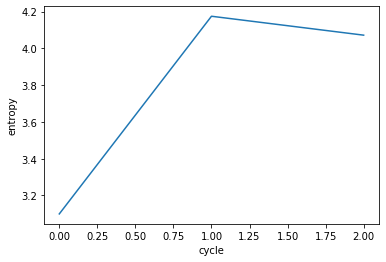

In [7]:
entropy = np.zeros(nsteps)
index = 0
# get the node that has the time history
gyre = info["expressions/entropy_of_gyre"]

# transfer conduit data to numpy
for i in range(gyre.number_of_children()):
    entropy[i] = gyre[i]["value"]

print(entropy)
# plot the data
plt.plot(entropy)
plt.ylabel('entropy')
plt.xlabel('cycle')
plt.show()

### Three good changes to explore

- Data set dims
- Field and Plot Type
